# Исследование рынка заведений общественного питания Москвы 

**Цель исследования** - провести исследовательский анализ рынка заведений общественного питания в Москве и подготовить презентацию для потенциальных инвесторов, которые смогут использовать её для оценки инвестиционной привлекательности открытия нового ресторана.

**Ход исследования**

Для проекта будут использованы открытые данные о заведениях общепита - адрес, количество посадочных мест, факт пренадлежности к какой-либо сети, а также тип предприятия по классификации заведений общественного питания в РФ <a href="https://docs.cntd.ru/document/1200107325">(**ГОСТ 30389-2013**)</a>. Данные будут предобработаны и проанализированы, а на основании сделаных выводов будет подготовлена презентация для инвесторов. Таким образом, исследование будет разбито на следующие этапы:

1. [**Обзор и предобработка данных**](#overview)
2. [**Исследовательский анализ данных**](#EDA)
3. [**Общий вывод и рекомендации**](#presentation)

<a id='overview'></a>

## Обзор и предобработка данных

Данные представлены в файле `rest_data.csv`.

Описание данных:

 * `id` — идентификатор объекта;
 * `object_name` — название объекта общественного питания;
 * `chain` — сетевой ресторан;
 * `object_type` — тип объекта общественного питания;
 * `address` — адрес;
 * `number` — количество посадочных мест.
 
Загрузим данные и выведем основную информацию о таблице:

In [1]:
# импортируем необходимые библиотеки

import os
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import re

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
np.set_printoptions(threshold=np.inf)
sns.set_style('whitegrid')
plt.rcParams.update({'axes.labelsize': 10,'axes.titlesize': 15})
os.chdir('C:\\Users\\dmitr\\GitHub\\Practicum-Data-Analysis\\datasets')

In [2]:
# загружаем данные, выводим основную информацию и 5 случайных строк

data = pd.read_csv('rest_data.csv')
data.info()
data.sample(5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
2973,22736,Луна,нет,кафе,"город Москва, Михалковская улица, дом 38, стро...",40
2593,29065,Столовая ГБОУ 45 Гимназия имени Л.И. Мильграмма,нет,столовая,"город Москва, улица Гримау, дом 8",300
6737,23349,Столовая ГБОУ СОШ № 1900,нет,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240
14940,222539,Holy Vegan,нет,кафе,"город Москва, Ходынский бульвар, дом 4",0
4088,26585,Ресторан «Очаг гурманов»,нет,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42


Таблица содержит 6 столбцов и 15,366 строк. Рассмотрим каждый столбец по отдельности c помощью функции:

In [3]:
original = data # на всякий случай сделаем переменную с сырым датасетом

# создадим список с названиями колонок
# аргументом функции будет являтся индекс этого списка

col = data.columns.tolist()


# функция "overview" выведет описательную статистику данных столбца.
# если есть пропуски - выведет их количество и процентную долю от общего числа значений

def overview(index):
    
    column = data[col[index]]
    na = column.isna().sum() # количество пропусков
    
    print(column.describe()) # описательная статистика
    print(f'data type - {column.dtypes}') # тип данных столбца
    
    if na > 1: # если есть пропуски:
        
        print()
        print(f'cells with missing data = {na}') # количества пропусков
        print(f'missing data share = {round(na/len(column)*100, 2)}%') # доля пропусков в %       
    else:
        print()
        print('no missing cells')

# опробуем функцию overview на первом столбце

try:
    overview(0) # столбец с названием заведения
    
except:
    print('Функция не сработала.') 

count    15,366.00
mean    119,720.07
std      73,036.13
min         838.00
25%      28,524.00
50%     144,974.50
75%     184,262.25
max     223,439.00
Name: id, dtype: float64
data type - int64

no missing cells


Этот столбец содержит уникальный идентификатор предприятия общественного питания. Числовой тип тут неуместен, потому сохраним данные как текст и проверим их уникальность:

In [4]:
data['id'] = data['id'].astype('string') # меняем тип данных
overview(0) # снова вызываем функцию

count      15366
unique     15366
top       151635
freq           1
Name: id, dtype: object
data type - string

no missing cells


Переходим к следующему столбцу:

In [5]:
overview(1) # столбец с названием заведения

count        15366
unique       10393
top       Столовая
freq           267
Name: object_name, dtype: object
data type - object

no missing cells


Посмотрим уникальные значения столбца:

In [6]:
data['object_name'].sort_values().unique() # выводим уникальные значения

array(['1-ЫЙ МОСКОВСКИЙ КАДЕТСКИЙ КОРПУС', '1-й МОК',
       '100 личная столовая', '100 личное кафе', '1001 ночь', '100лоФФка',
       '101 вкус', '13 RULES', '13 RULES KRAFT BEER', '13 Rules',
       '15 Kitchen+bar', '18 АВТОБУСНЫЙ ПАРК', '19bar Atmosphere',
       '1x bet', '2-Й АВТОБУСНЫЙ ПАРК', "23'00", '24 Градуса', '259',
       '3 Skovorodki', '3 правила', '33 пингвина', '37-37', '44 Чашма',
       '495', '5звезд Юг 52', '68. ПАУЗА', '69 Pints Бар', '69 pints',
       '7 Сендвичей', '7 злаков', '7 сэндвичей-Meating',
       '7717 LOUNGE (Кальянная)', '8 OZ Унций', '8-ОЙ ТРОЛЛЕЙБУСНЫЙ ПАРК',
       '9 АВТОБУСНЫЙ ПАРК', '9bar', 'ABC Coffee Roasters', 'ACCENTI',
       'ADRY', 'AGLOMERAT', 'AL33 Пиццерия Бар Ботега', 'ALOHA POKE BAR',
       'AMARSI', 'AMG', 'APARTAMENT Пар Бар', 'AQKitchen', 'ART PUB',
       'Abbey Players Irish Pub', 'Absolem', 'Acai Family',
       'Alex Пекарня', 'Amande Cafe', 'Americano Кафе', 'Amerigos Pizza',
       'Amore Grande', 'Amore, итальянское мо

In [7]:
data['object_name'].str.lower().value_counts()

столовая                      321
кафе                          278
шаурма                        250
шоколадница                   158
kfc                           155
                             ... 
столовая гуп «мосгортранс»      1
пиццерия «алло пицца»           1
bizone антикафе                 1
сирень                          1
кальянная «мята lounge»         1
Name: object_name, Length: 9924, dtype: int64

* Даже при поверхостном осмотре списка выше можно заметить множество неявных дубликатов, в основном обусловленных наличием опечаток или использованием разных регистров. В рамках исследования тщательная обработка названий заведений не оправдана - данных остальных столбцов будет достаточно для большинства необходимых выводов.

Для уменьшения количества дубликатов названия будут приведены к нижнему регистру - таким образом можно будет выделить самые крупные сети. Так как пропущенные значения отсутствуют, данные этого столбца также можно преобразовать в текст:

In [8]:
# меняем тип данных и регистр

data['object_name'] = (
    data['object_name']
    .str.lower()
    .astype('string')
) 

Переходим дальше:

In [9]:
overview(2) # пренадлежность к сети ресторанов

count     15366
unique        2
top         нет
freq      12398
Name: chain, dtype: object
data type - object

no missing cells


Для экономии памяти данные этого столбца можно преобразовать в тип `boolean`:

In [10]:
data['chain'] = data['chain'].replace({'да' : True, 'нет': False})

Переходим дальше:

In [11]:
overview(3) # тип заведения

count     15366
unique        9
top        кафе
freq       6099
Name: object_type, dtype: object
data type - object

no missing cells


In [12]:
data['object_type'].unique() # проверим уникальность значений

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Для удобства визуализации данных сократим слишком длинные названия типов предприятий.  Для экономии памяти мы можем преобразовать данные в тип категорий:

In [13]:
# меняем тип данных, сокращаем длинные значения

data['object_type'] = (
    data['object_type']
    .replace({'предприятие быстрого обслуживания': 'фаст-фуд',
              'магазин (отдел кулинарии)':'кулинария'})
    .astype('category')
) 

Следующий столбец - один из ключевых для исследования:

In [14]:
overview(4) # адрес заведения

count                                      15366
unique                                      9108
top       город Москва, Ходынский бульвар, дом 4
freq                                          95
Name: address, dtype: object
data type - object

no missing cells


Сам по себе полный адрес не несёт большой пользы - слишком много уникальных значений, что сделает невозможным какую-либо категоризацию. Намного информативнее будет название улицы и округ/район, в котором находится ресторан.

In [15]:
# сначала попробуем разбить адрес на части

address_split = data['address'].str.split(',', expand=True)
address_split

,0,1,2,3,4,5,6
0,город Москва,улица Егора Абакумова,дом 9,None,None,None,None
1,город Москва,улица Талалихина,дом 2/1,корпус 1,None,None,None
2,город Москва,Абельмановская улица,дом 6,None,None,None,None
3,город Москва,Абрамцевская улица,дом 1,None,None,None,None
4,город Москва,Абрамцевская улица,дом 9,корпус 1,None,None,None
...,...,...,...,...,...,...,...
15361,город Москва,3-й Крутицкий переулок,дом 18,None,None,None,None
15362,город Москва,улица Земляной Вал,дом 33,None,None,None,None
15363,город Москва,улица Земляной Вал,дом 33,None,None,None,None
15364,город Москва,поселение Московский,Киевское шоссе,22-й километр,домовладение 4,строение 1,None


In [16]:
# посмотрим, все ли адреса начинаются одинаково

address_split[0].value_counts()

город Москва                     15295
улица Ленинская Слобода              4
Николоямская улица                   4
город Московский                     3
улица Льва Толстого                  3
Солянский тупик                      3
2-я Брестская улица                  2
Партизанская улица                   2
Ленинградский проспект               2
Таганская площадь                    2
Бауманская улица                     2
улица Сергея Макеева                 1
Медынская улица                      1
Чертановская улица                   1
Шарикоподшипниковская улица          1
Варшавское шоссе                     1
улица Миклухо-Маклая                 1
1-я Тверская-Ямская улица            1
Краснобогатырская улица              1
город Троицк                         1
Таганская улица                      1
Садовая-Сухаревская улица            1
Коровинское шоссе                    1
Суворовская площадь                  1
Тушинская улица                      1
Вознесенский переулок    

Абсолютное большинство адресов начинается с `город Москва` - для упрощения обработки значений мы добавим город во все остальные адреса:

In [17]:
# укажем город во всех адресах

data.loc[~(data['address'].str.startswith('город')), 'address'] = (
    'город Москва, ' + data.loc[~(data['address'].str.startswith('город')), 'address']
)

Теперь когда мы представляем, как выглядит типичный адрес заведения, попробуем использовать регулярное выражение для извлечения названия улицы из адреса:

In [18]:
# создаём список со всеми возможными наименованиями улиц

str_types = ['улица','переулок','шоссе',
             'проспект','площадь', 'проезд', 
             'микрорайон', 'территория','село',
             'аллея','бульвар','набережная',
             'тупик','линия','квартал', 'город', 
             'поселение', 'посёлок', 'просек', '-й километр']

# пишем регулярное выражение, опираясь на запятые адреса

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(str_types))

# извлекаем название улицы в новый столбец

data["street"] = data["address"].str.extract(str_pat, flags=re.I)

# смотрим на обновлённый датафрейм, проверяем пропуски

display(data.sample(15, random_state=1))

data.isna().sum()

,id,object_name,chain,object_type,address,number,street
2973,22736,луна,False,кафе,"город Москва, Михалковская улица, дом 38, стро...",40,Михалковская улица
2593,29065,столовая гбоу 45 гимназия имени л.и. мильграмма,False,столовая,"город Москва, улица Гримау, дом 8",300,улица Гримау
6737,23349,столовая гбоу сош № 1900,False,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240,Дубравная улица
14940,222539,holy vegan,False,кафе,"город Москва, Ходынский бульвар, дом 4",0,Ходынский бульвар
4088,26585,ресторан «очаг гурманов»,False,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42,Каширское шоссе
5910,28867,школа 775,False,буфет,"город Москва, Армавирская улица, дом 4",210,Армавирская улица
10541,187743,24 градуса,False,бар,"город Москва, Митинская улица, дом 36",4,Митинская улица
14563,217236,чайхана ош,False,ресторан,"город Москва, проспект Андропова, дом 36",49,проспект Андропова
10497,182718,abc coffee roasters,False,кафе,"город Москва, улица Покровка, дом 7/9-11, корп...",15,улица Покровка
7708,111069,кафе иль патио «il patio»,True,кафе,"город Москва, Каширское шоссе, дом 26",176,Каширское шоссе


id             0
object_name    0
chain          0
object_type    0
address        0
number         0
street         0
dtype: int64

Получилось! Теперь обратимся к внешним источникам для определения района и административного округа:

In [19]:
# используем данные компании АО "Мосгаз"

district = (
    pd.read_csv('https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv')
)

# смотрим на таблицу

district.info()
district.sample(15, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   streetname  4398 non-null   object
 1   areaid      4398 non-null   int64 
 2   okrug       4398 non-null   object
 3   area        4398 non-null   object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB


,streetname,areaid,okrug,area
854,Суздальская улица,30,ВАО,Район Новокосино
1925,Малое кольцо Московской железной дороги (МКМЖД),56,САО,Бескудниковский Район
2330,Ленская улица,72,СВАО,Бабушкинский район
2040,Большая Академическая улица,62,САО,Район Коптево
1758,Ленинградское шоссе,52,Зеленоград,Район Матушкино-Савелки
453,2-й Тверской-Ямской переулок,19,ЦАО,Тверской район
4360,Малый Сергиевский переулок,16,ЦАО,Мещанский район
3654,3-я Фрунзенская улица,20,ЦАО,Район Хамовники
3854,проспект 60-летия Октября,123,ЮЗАО,Академический район
1060,15-я Парковая улица,24,ВАО,Район Восточное Измайлово


In [20]:
# проверим дубликаты

district[district['streetname'].duplicated()]

,streetname,areaid,okrug,area
312,площадь Варварские Ворота,19,ЦАО,Тверской район
321,улица Гашека,19,ЦАО,Тверской район
323,Большая Никитская улица,19,ЦАО,Тверской район
324,Большой Гнездниковский переулок,19,ЦАО,Тверской район
325,Малый Гнездниковский переулок,19,ЦАО,Тверской район
...,...,...,...,...
4385,Благовещенский переулок,17,ЦАО,Пресненский район
4388,2-я Брестская улица,17,ЦАО,Пресненский район
4389,Большая Бронная улица,17,ЦАО,Пресненский район
4392,Васильевская улица,17,ЦАО,Пресненский район


In [21]:
# посмотрим на данные одной из задублированных улиц

district[district['streetname'] == 'улица Гашека']

,streetname,areaid,okrug,area
1,улица Гашека,17,ЦАО,Пресненский район
321,улица Гашека,19,ЦАО,Тверской район


* Согласно <a href="https://ru.wikipedia.org/wiki/%D0%A3%D0%BB%D0%B8%D1%86%D0%B0_%D0%93%D0%B0%D1%88%D0%B5%D0%BA%D0%B0_(%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0)">статье на Википедии</a>, эта улица действительно находится одновременно в двух разных районах Москвы. Это довольно характерный случай для Москвы, потому вероятнее всего это причина всех дубликатов. Для дальнешей работы с данными все названия улиц должны быть уникальными, потому при формировании выводов необходимо будет сделать поправку на точность распределения заведений по районам:

In [22]:
# удаляем дубликаты

district = district.drop_duplicates(subset=['streetname'])

# объединяем таблицы, удаляем лишние столбцы

data = (
    data
    .merge(district
           .rename(columns={'okrug':'area','area':'district'}), 
           left_on='street', 
           right_on='streetname', 
           how='left')
    .drop(['streetname', 'areaid'], axis=1)
)

In [23]:
# смотрим на обновлённую таблицу

data.info()
data.sample(15, random_state=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           15366 non-null  string  
 1   object_name  15366 non-null  string  
 2   chain        15366 non-null  bool    
 3   object_type  15366 non-null  category
 4   address      15366 non-null  object  
 5   number       15366 non-null  int64   
 6   street       15366 non-null  object  
 7   area         14677 non-null  object  
 8   district     14677 non-null  object  
dtypes: bool(1), category(1), int64(1), object(4), string(2)
memory usage: 990.8+ KB


,id,object_name,chain,object_type,address,number,street,area,district
2973,22736,луна,False,кафе,"город Москва, Михалковская улица, дом 38, стро...",40,Михалковская улица,САО,Головинский район
2593,29065,столовая гбоу 45 гимназия имени л.и. мильграмма,False,столовая,"город Москва, улица Гримау, дом 8",300,улица Гримау,ЮЗАО,Академический район
6737,23349,столовая гбоу сош № 1900,False,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240,Дубравная улица,СЗАО,Район Митино
14940,222539,holy vegan,False,кафе,"город Москва, Ходынский бульвар, дом 4",0,Ходынский бульвар,САО,Хорошевский район
4088,26585,ресторан «очаг гурманов»,False,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42,Каширское шоссе,ЮАО,Район Москворечье-Сабурово
5910,28867,школа 775,False,буфет,"город Москва, Армавирская улица, дом 4",210,Армавирская улица,ЮВАО,Район Люблино
10541,187743,24 градуса,False,бар,"город Москва, Митинская улица, дом 36",4,Митинская улица,СЗАО,Район Митино
14563,217236,чайхана ош,False,ресторан,"город Москва, проспект Андропова, дом 36",49,проспект Андропова,ЮАО,Даниловский район
10497,182718,abc coffee roasters,False,кафе,"город Москва, улица Покровка, дом 7/9-11, корп...",15,улица Покровка,ЦАО,Басманный район
7708,111069,кафе иль патио «il patio»,True,кафе,"город Москва, Каширское шоссе, дом 26",176,Каширское шоссе,ЮАО,Район Москворечье-Сабурово


Проверим пропущенные значения:

In [24]:
na = data.isna().sum()

print('missing value count')
print()
print(na)

missing value count

id               0
object_name      0
chain            0
object_type      0
address          0
number           0
street           0
area           689
district       689
dtype: int64


In [25]:
# расчитаем долю пропусков
print(f'missing value share is {round(na.sum()/2/len(data)*100, 2)}%')

missing value share is 4.48%


Видимо при объединении таблиц не все адреса совпали. Так как доля пропусков составляет меньше 5%, мы можем удалить эти данные без значительного влияния на результаты исследования:

In [26]:
data = (
    data
    .dropna()
    .reset_index(drop=True)
)
data

,id,object_name,chain,object_type,address,number,street,area,district
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,СВАО,Ярославский Район
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,ЦАО,Таганский район
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,ЦАО,Таганский район
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,СВАО,Район Лианозово
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,СВАО,Район Лианозово
...,...,...,...,...,...,...,...,...,...
14672,219759,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова,ЮАО,Донской район
14673,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок,ЦАО,Таганский район
14674,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал,ЦАО,Таганский район
14675,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал,ЦАО,Таганский район


Обновлённая таблица теперь содержит название улицы и наименование административного округа и района, что послужит основой для категоризации во время исследовательского анализа данных. Преобразуем данные адреса в текст,  обновим список названий колонок и и перейдём к следующему столбцу:

In [27]:
# меняем тип данных

data['address'] = data['address'].astype('string')

col = data.columns.tolist()

In [28]:
overview(5) # вместимость заведения

count   14,677.00
mean        60.44
std         75.16
min          0.00
25%         14.00
50%         40.00
75%         80.00
max      1,700.00
Name: number, dtype: float64
data type - int64

no missing cells


Максимальная вместимость составляет 1,700 человек. Учитывая такой разброс значений, данные можно сократить до `int16` для экономии памяти.

In [29]:
# меняем тип данных

data['number'] = data['number'].astype('int16') 

# переименуем столбец, для большей информативности

data = data.rename(columns={'number':'capacity'}) 

Разделим заведения на категории в зависимости от вместимости, используя квартили - в зависимости от категории заведения можно будет охарактеризовать в дальнейшем исследовании: 

In [30]:
# функция для расчёта перцентеля

def cap_perc(val):
    perc = np.percentile(data['capacity'], val)
    return perc
    
# функция для определения категории вместимости    
    
def cap_category(val):
    if val <= cap_perc(25):
        return 'small'
    if val <= cap_perc(50):
        return 'medium'
    if val <= cap_perc(75):
        return 'big'
    else:
        return 'large'
    
data['cap_category'] = data['capacity'].apply(cap_category).astype('category')
data

,id,object_name,chain,object_type,address,capacity,street,area,district,cap_category
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,СВАО,Ярославский Район,big
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,ЦАО,Таганский район,medium
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,ЦАО,Таганский район,large
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,СВАО,Район Лианозово,medium
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,СВАО,Район Лианозово,big
...,...,...,...,...,...,...,...,...,...,...
14672,219759,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова,ЮАО,Донской район,medium
14673,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок,ЦАО,Таганский район,big
14674,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал,ЦАО,Таганский район,small
14675,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал,ЦАО,Таганский район,medium


Переходим дальше:

In [31]:
overview(6) # название улицы

count             14677
unique             1810
top       проспект Мира
freq                204
Name: street, dtype: object
data type - object

no missing cells


Здесь также можно представить данные в виде текста:

In [32]:
data['street'] = data['street'].astype('string') # меняем тип данных

In [33]:
overview(7) # административный округ

count     14677
unique       10
top         ЦАО
freq       4437
Name: area, dtype: object
data type - object

no missing cells


Проверим уникальные значения:

In [34]:
data['area'].value_counts()

ЦАО           4437
ЮАО           1994
ЗАО           1422
САО           1347
СВАО          1346
ВАО           1287
ЮЗАО           925
ЮВАО           849
СЗАО           729
Зеленоград     341
Name: area, dtype: int64

* ЦАО с большим отрывом лидирует по количеству заведений

Эти данные можно представить в виде категорий:

In [35]:
data['area'] = data['area'].astype('string')

In [36]:
overview(8) # название района

count              14677
unique               122
top       Тверской район
freq                 977
Name: district, dtype: object
data type - object

no missing cells


Проверим уникальные значения:

In [37]:
data['district'].unique()

array(['Ярославский Район', 'Таганский район', 'Район Лианозово',
       'Район Арбат', 'Район Лефортово', 'Район Солнцево', 'Район Зюзино',
       'Район Коптево', 'Район Гольяново', 'Алтуфьевский район',
       'Район Свиблово', 'Бабушкинский район', 'Дмитровский район',
       'Даниловский район', 'Район Фили-Давыдково',
       'Красносельский район', 'Район Южное Тушино', 'Район Сокольники',
       'Академический район', 'Район Царицыно',
       'Район Чертаново Северное', 'Район Аэропорт',
       'Район Филевский Парк', 'Басманный район', 'Район Замоскворечье',
       'Савеловский район', 'Район Беговой', 'Район Хорошево-Мневники',
       'Район Люблино', 'Район Дорогомилово', 'Бескудниковский Район',
       'Район Отрадное', 'Район Щукино', 'Район Богородское',
       'Нагорный район', 'Район Северное Бутово', 'Район Марфино',
       'Останкинский район', 'Тверской район', 'Пресненский район',
       'Район Ростокино', 'Район Соколиная Гора',
       'Район Бирюлево Западное', 'Ра

Дубликатов нет, данные выглядят хорошо. Осталось только поменять тип данных:

In [38]:
data['district'] = data['district'].astype('string')

Последний шаг - проверим датасет на дубликаты, исключив столбец с уникальными идентификаторами:

In [39]:
cols = data.columns.to_list()

data[data.duplicated(subset=cols[1:])]

,id,object_name,chain,object_type,address,capacity,street,area,district,cap_category
2333,28611,комбинат питания мгту им.н.э.баумана,False,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100,2-я Бауманская улица,ЦАО,Басманный район,large
3339,71896,буфет «коникс-школьник»,False,буфет,"город Москва, улица Удальцова, дом 21",100,улица Удальцова,ЗАО,Район Проспект Вернадского,large
3421,20914,буфет мади,False,буфет,"город Москва, Ленинградский проспект, дом 64",40,Ленинградский проспект,САО,Район Аэропорт,medium
4367,23759,столовая гбоу города москвы № 384,False,буфет,"город Москва, Беловежская улица, дом 67",100,Беловежская улица,ЗАО,Можайский Район,large
4473,23391,столовая «комбинат питания космос»,False,столовая,"город Москва, Новозаводская улица, дом 12/11",15,Новозаводская улица,ЗАО,Район Филевский Парк,medium
...,...,...,...,...,...,...,...,...,...,...
13976,222932,старый баку,False,кафе,"город Москва, Кировоградская улица, владение 15А",120,Кировоградская улица,ЮАО,Район Чертаново Центральное,large
13994,204947,буфет при кинотеатре,False,буфет,"город Москва, Ореховый бульвар, дом 22А",0,Ореховый бульвар,ЮАО,Район Орехово-Борисово Южное,small
14213,219518,sushi-make,False,фаст-фуд,"город Москва, Ярцевская улица, дом 19",0,Ярцевская улица,ЗАО,Район Кунцево,small
14494,218542,кофе с собой,True,фаст-фуд,"город Москва, Алтуфьевское шоссе, дом 70, корп...",0,Алтуфьевское шоссе,СВАО,Алтуфьевский район,small


Нашлась 81 задублированная строка - их удаление не повлияет на результаты исследования, потому целесообразнее будет избавиться от них:

In [40]:
data = data.drop_duplicates(subset=cols[1:])

### Итоги

В начале предобработки данных сырой датасет был сохранён в переменную `original`. Сравним первоначальные и измененные в ходе обработки данные:

In [41]:
original

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,шоколадница,True,кафе,"город Москва, поселение Московский, Киевское ш...",36,22-й километр


In [42]:
data

,id,object_name,chain,object_type,address,capacity,street,area,district,cap_category
0,151635,сметана,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,СВАО,Ярославский Район,big
1,77874,родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,ЦАО,Таганский район,medium
2,24309,кафе «академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,ЦАО,Таганский район,large
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,СВАО,Район Лианозово,medium
4,119365,кафе «вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,СВАО,Район Лианозово,big
...,...,...,...,...,...,...,...,...,...,...
14672,219759,шоколадница,True,кафе,"город Москва, улица Вавилова, дом 3",36,улица Вавилова,ЮАО,Донской район,medium
14673,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок,ЦАО,Таганский район,big
14674,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал,ЦАО,Таганский район,small
14675,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал,ЦАО,Таганский район,medium


In [43]:
# посчитаем разницу в количестве строк и используемых ресурсов памяти

size_diff = round((len(original)-len(data))/len(original)*100, 2)
memory_diff = round((3.7-3)/3*100, 2)


print(f'В ходе предобработки данных было удалено {size_diff}% датасета,\n '
      f'при этом удалось сократить использование памяти на {memory_diff}%.')

print()
data.info()
data.sample(10, random_state=1)

В ходе предобработки данных было удалено 5.01% датасета,
 при этом удалось сократить использование памяти на 23.33%.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14596 entries, 0 to 14676
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            14596 non-null  string  
 1   object_name   14596 non-null  string  
 2   chain         14596 non-null  bool    
 3   object_type   14596 non-null  category
 4   address       14596 non-null  string  
 5   capacity      14596 non-null  int16   
 6   street        14596 non-null  string  
 7   area          14596 non-null  string  
 8   district      14596 non-null  string  
 9   cap_category  14596 non-null  category
dtypes: bool(1), category(2), int16(1), string(6)
memory usage: 870.1 KB


,id,object_name,chain,object_type,address,capacity,street,area,district,cap_category
8921,166463,ресторан «verde»,False,ресторан,"город Москва, Садовая-Кудринская улица, дом 21...",35,Садовая-Кудринская улица,ЦАО,Пресненский район,medium
3313,27633,цо 345,False,столовая,"город Москва, Елоховский проезд, дом 1, строен...",100,Елоховский проезд,ЦАО,Басманный район,large
8881,161931,заяц и шляпа,False,кафе,"город Москва, Краснобогатырская улица, дом 90,...",35,Краснобогатырская улица,ВАО,Район Богородское,medium
7319,151646,предприятие быстрого обслуживания «бургер кинг»,True,фаст-фуд,"город Москва, Кировоградская улица, дом 14",24,Кировоградская улица,ЮАО,Район Чертаново Центральное,medium
9316,168576,кафе-бутик «leonidas»,False,кафе,"город Москва, Пятницкая улица, дом 53/18, стро...",10,Пятницкая улица,ЦАО,Район Замоскворечье,small
5447,117474,бургерная,False,кафе,"город Москва, 1-я улица Бухвостова, дом 12/11,...",20,1-я улица Бухвостова,ВАО,Район Преображенское,medium
12777,204112,семейное кафе андерсон,True,кафе,"город Москва, Таганская улица, дом 36, строение 1",80,Таганская улица,ЦАО,Таганский район,big
3442,21414,буфет школы № 1575,False,буфет,"город Москва, улица Усиевича, дом 6",45,улица Усиевича,САО,Район Аэропорт,big
5595,141206,"ресторан-бар, ночной клуб «адмирал»",False,ресторан,"город Москва, Измайловское шоссе, дом 71А",50,Измайловское шоссе,ВАО,Район Измайлово,big
8500,24987,шаурма на углях-чайхана баракат,False,кафе,"город Москва, Таганская площадь, дом 88, строе...",80,Таганская площадь,ЦАО,Таганский район,big


При обработке удалось сохранить большую часть данных, а за счёт изменения типа данных - значительно сократить используемые ресурсы памяти, несмотря на присоединение нескольких столбцов другой таблицы
_______
**Что было отмечено при работе с данными:**

* Названия предприятий содержат множество неявных дубликатов, в основном обусловленных наличием опечаток или использованием разных регистров. В рамках исследования обработка названий заведений не оправдана - данных остальных столбцов будет достаточно для необходимых выводов.


* Некоторые улицы относятся одновременно к двум разным районам Москвы. В рамках исследования соотносить улицу с двумя районами технически невозможно, потому для каждой из них в случайном порядке был оставлен лишь одна локация - при формировании выводов необходимо будет сделать поправку на точность распределения заведений по районам.


* Округ ЦАО с большим отрывом лидирует по количеству заведений

<a id='EDA'></a>

## Исследовательский анализ данных
В ходе анализа будут выполнены следующие шаги:

1. [**Исследования соотношения количества объектов общественного питания**](#EDA1)
2. [**Исследование соотношения количества посадочных мест в заведениях**](#EDA2)
3. [**Исследование распределения заведений по локациям**](#EDA3)

<a id='EDA1'></a>

### Исследования соотношения количества объектов общественного питания
Количество заведений будет рассмотрено в разрезе видов предприятий и отношения к какой-либо сети. Для начала сгруппируем данные:

In [44]:
# сделаем копию датасета для исследовательского анализа

eda = data

# группируем данные

df = (
    eda
    .pivot_table(index='object_type', 
                 values='id',
                 aggfunc='count'
                )
    .rename(columns={'id':'object_count'})
    .sort_values('object_count', ascending=False)
    .reset_index()
)

# для визуализации долей возьмём пять самых крупных видов заведений

eda_top_5 = (
    df[:5]
    .append({'object_type':'другие', 'object_count': (df[5:]['object_count'].sum())},
           ignore_index=True)
)

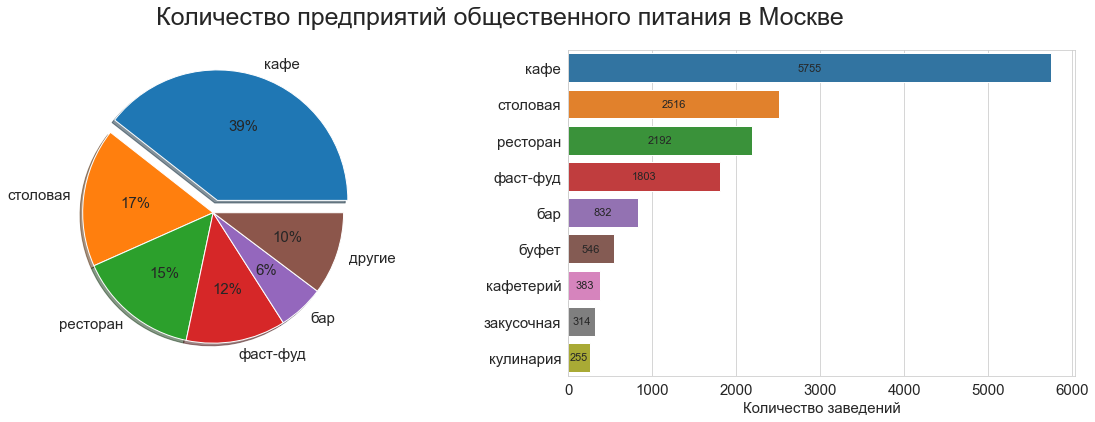

In [45]:
# строим график соотношения

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

labels = df['object_type'].to_list()
sns.barplot(data=df, y='object_type', 
            x='object_count', order=labels, ax=ax2)

ax1.pie(eda_top_5['object_count'], 
        labels=eda_top_5['object_type'],
        autopct='%.0f%%', textprops={'fontsize':15},
        explode=[0.1, 0, 0, 0, 0, 0],
        shadow=True
       )

ax2.tick_params(labelsize=15)
ax2.set_ylabel('')
ax2.set_xlabel('Количество заведений', size=15)
ax2.bar_label(ax2.containers[0], size=11, label_type='center')

fig.suptitle('Количество предприятий общественного питания в Москве', size=25)

plt.show()

- Доля кафе составляет 40% от всех заведений. Вместе со столовыми, ресторанами, предприятиями быстрого питания и барами они составляют 90% всех предприятий Москвы.

Для дальнейшего исследования остальные виды предприятий рассматривать нецелесообразно - объединим их в отдельную категорию `другие`. 

Следующий шаг - исследование соотношения сетевых и несетевых предприятий.

In [46]:
# группируем данные

# таблица с сетевыми предприятиями

chains = (
    eda[eda['chain'] == True]
    .pivot_table(index='object_type', 
                 values='id',
                 aggfunc='count'
                )
    .rename(columns={'id':'object_count'})
    .sort_values('object_count', ascending=False)
    .reset_index()
)

# общее соотношение

ch_ratio = (
    eda
    .pivot_table(index='chain', 
                 values='id', 
                 aggfunc='count')
    .sort_values(['id'])
)

# добавляем количество сетевых заведений в общий датафрейм

df = (
    df
    .merge(chains, on='object_type', how='left')
    .rename(columns={'object_count_x':'total_objects', 
                     'object_count_y':'chain_objects'})
    
)

# оставляем топ-5 видов заведений, остальные объединяем

df = (
    df[:5]
    .append({'object_type':'другие', 
             'total_objects': (df[5:]['total_objects'].sum()),
             'chain_objects': (df[5:]['chain_objects'].sum())},
           ignore_index=True)
)

# считаем долю сетевых предприятий

df['chain_ratio'] = (
    round(df['chain_objects']/df['total_objects']*100, 2)
)

# смотрим на результат

df

,object_type,total_objects,chain_objects,chain_ratio
0,кафе,5755,1352,23.49
1,столовая,2516,3,0.12
2,ресторан,2192,516,23.54
3,фаст-фуд,1803,743,41.21
4,бар,832,37,4.45
5,другие,1498,194,12.95


- Значительная доля сетевых заведений наблюдается только у кафе, ресторанов и преприятий быстрого питания.

Визуализируем соотношений сетевых и несетевых заведений по количеству:

In [47]:
# напишем функцию для вывода топа заведений по заданному параметру

def top(val, par):    
    top = (
        df.sort_values(par, ascending=False)[:val]
          .append({'object_type':'другие', 
                   par: (df.sort_values(par, ascending=False)[val:][par].sum())},
               ignore_index=True)
    )
    return top[['object_type', par]]

# сделаем топ-3 вида заведений по количеству сетевых

top(3, 'chain_ratio')

,object_type,chain_ratio
0,фаст-фуд,41.21
1,ресторан,23.54
2,кафе,23.49
3,другие,17.52


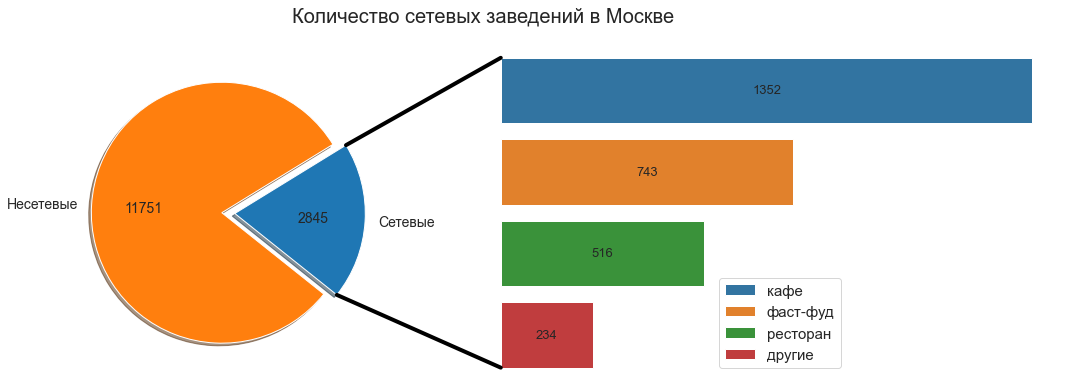

In [48]:
# строим график

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(wspace=0)

# круговая диаграмма

angle = -180 * (ch_ratio['id'].sum()/ch_ratio['id'][0]-1) + 5
values = lambda p: '{:.0f}'.format(p * ch_ratio['id'].sum() / 100)
wedges, *_ = ax1.pie(ch_ratio['id'], autopct=values, #autopct='%1.1f%%', 
                     startangle=angle, shadow=True, textprops={'fontsize': 14},
                     labels=['Сетевые', 'Несетевые'], explode=[0.1, 0])

# линейчатая диаграмма

top_3 = top(3, 'chain_objects')

sns.barplot(data=top_3, y='object_type',
            x='chain_objects', hue='object_type', 
            ax=ax2, dodge=False
           )
for i in range(len(top_3)):
    ax2.bar_label(ax2.containers[i], size=13, label_type='center')

    
# соединяем графики

theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = 1
bottom = 1
width = .2

# функция для линий, соединяющей графики

def connect(par_1, theta):

    x = r * np.cos(np.pi / 180 * theta) + center[0]
    y = r * np.sin(np.pi / 180 * theta) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, par_1), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(4)
    ax2.add_artist(con)


connect(-.4, theta2) # верхняя линия
connect(3.4, theta1) # нижняя линия

ax2.axis('off')
fig.suptitle('Количество сетевых заведений в Москве', size=20, va='top')

plt.legend(loc='lower center', prop={'size': 15})

plt.show()

- Кафе, рестораны и преприятия быстрого питания составляют около 90% всех сетевых заведений.

Визуализируем долю сетевых предприятий внутри этих видов заведений:

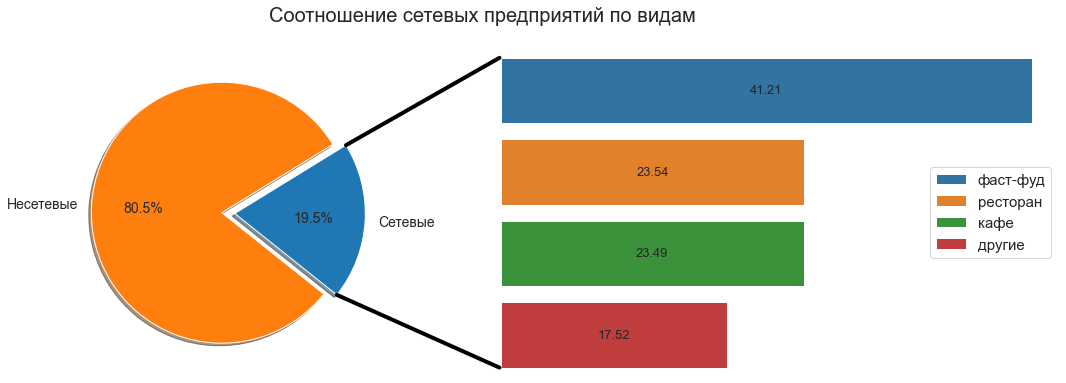

In [49]:
# строим график

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(wspace=0)

# круговая диаграмма

angle = -180 * (ch_ratio['id'].sum()/ch_ratio['id'][0]-1) + 5
values = lambda p: '{:.0f}'.format(p * ch_ratio['id'].sum() / 100)
wedges, *_ = ax1.pie(ch_ratio['id'], autopct='%1.1f%%', 
                     startangle=angle, shadow=True, textprops={'fontsize': 14},
                     labels=['Сетевые', 'Несетевые'], explode=[0.1, 0])

# линейчатая диаграмма

top_3 = top(3, 'chain_ratio')

sns.barplot(data=top_3, y='object_type',
            x='chain_ratio', hue='object_type', 
            ax=ax2, dodge=False
           )
for i in range(len(top_3)):
    ax2.bar_label(ax2.containers[i], size=13, label_type='center')

    
# соединяем графики

theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = 1
bottom = 1
width = .2

connect(-.4, theta2) # верхняя линия
connect(3.4, theta1) # нижняя линия

ax2.axis('off')
fig.suptitle('Соотношение сетевых предприятий по видам', size=20, va='top')

plt.legend(loc='right', prop={'size': 15})

plt.show()

- Сетевые предприятия составляют около 20% от всех заведений


- Несмотря на лидерство кафе по количеству сетевых заведений, предприятия быстрого обслуживания имеют самую значительную долю заведений, пренадлежащих к сети - 40%.

<a id='EDA2'></a>

### Исследование соотношения количества посадочных мест в заведениях

На этом этапе будет исследовано соотношения количества заведений и их вместимость для сетевых предприятий, а также среднее количество посадочных мест для каждого вида заведения.

In [50]:
# сгруппируем данные по имени заведения

chain_capacity = (
    eda
    .pivot_table(index='object_name',
                 values='capacity',
                 aggfunc=('mean', 'count')
                )
    .reset_index()
    .rename(columns={'count':'object_count',
                     'mean':'mean_capacity'
                    })
)

# оставим только те сети, где больше двух заведений

chain_capacity = chain_capacity[chain_capacity['object_count'] > 2]

# используем функцию для категоризации вместимости
# расчитанной по квартилям основного датафрейма

chain_capacity['size'] = chain_capacity['mean_capacity'].apply(cap_category)

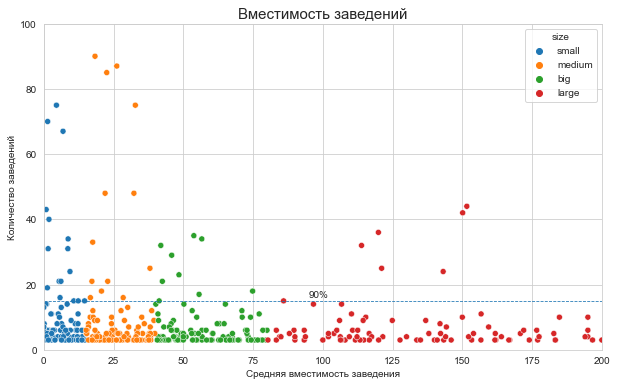


capacity/object count correlation


,object_count,mean_capacity
object_count,1.00,-0.07
mean_capacity,-0.07,1.00



object count per size


medium    125
small     119
big       118
large     117
Name: size, dtype: int64

In [51]:
# строим график

plt.figure(figsize=(10, 6))

sns.scatterplot(data = chain_capacity, 
                x='mean_capacity', 
                y='object_count',
                hue='size',
                hue_order = ['small', 'medium', 'big', 'large']
               )

plt.ylim(0, 100)
plt.xlim(0, 200)

plt.xlabel('Средняя вместимость заведения')
plt.ylabel('Количество заведений')
plt.title('Вместимость заведений')

plt.axhline(
    y=np.percentile(chain_capacity['object_count'], 90), 
    linestyle='--', linewidth= .8
)
plt.annotate('90%', xy=(95, 16))
plt.show()

# проверим наличие корреляции вместимости и количества объектов
# а также распределение категорий размера

print()
print('capacity/object count correlation')
display(chain_capacity.corr())
print()
print('object count per size')
display(chain_capacity['size'].value_counts())

In [52]:
np.percentile(chain_capacity['object_count'], 90)

15.0

- В целом соотношение размеров предприятий сопоставимо, с небольшим отрывом лидируют средние по вместимости заведения.


- Корреляция средней вместимости и количества предприятий в сети полностью отсутствует.

Теперь проанализируем количество посадочных мест по видам предприятий:

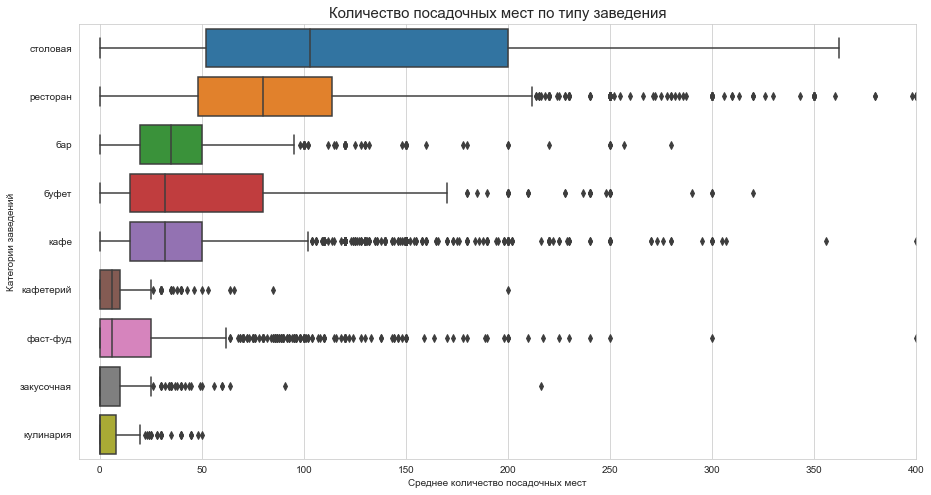

In [53]:
plt.figure(figsize=(15, 8))

order = (
    eda
    .groupby(by=["object_type"])["capacity"]
    .median()
    .sort_values(ascending=False)
    .index
)


sns.boxplot(x='capacity', y='object_type', 
            data=eda, order=order)

plt.title('Количество посадочных мест по типу заведения')
plt.xlim(-10, 400)
plt.xlabel('Среднее количество посадочных мест')
plt.ylabel('Категории заведений')

plt.show()

- Столовые лидируют по количеству посадочных мест. Этот тип характерен не только высоким медианым значением, но и самым широким разбросом нормальных значений.

<a id='EDA3'></a>

### Исследование распределения заведений по локациям

В ходе предобработки данных нам удалось выделить из адресов заведений улицу, район и административный округ - составим топ-10 предприятий по каждому из этих параметров:

In [54]:
# функция для определения топа по локациям

def top_locations(area):
    
    top = (
        eda
        .pivot_table(index=area, 
                     values='id', aggfunc='count')
        .rename(columns={'id':'object_count'})    
        .sort_values('object_count', ascending=False)
        .reset_index()
    )
    
    return top

# выводим топ-10 улиц, с указанием района

top_10_streets = top_locations(('street', 'district'))[:10]

top_10_streets['street'] = (
    top_10_streets['street'] + ', ' + top_10_streets['district']
)
top_10_streets = top_10_streets.drop('district', axis=1)

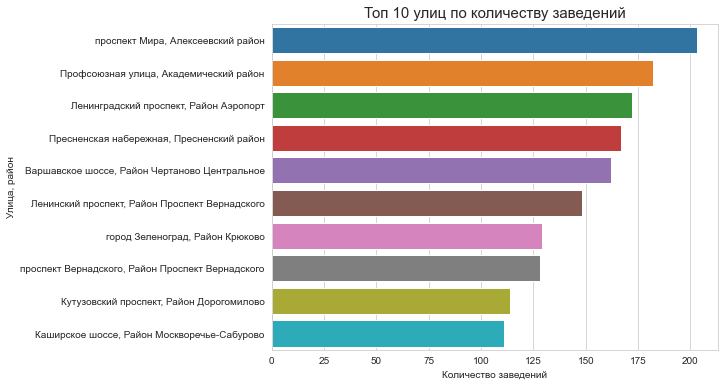

In [55]:
# визуализируем результат

plt.figure(figsize=(8, 6))

sns.barplot(data = top_10_streets, 
            x='object_count', y='street')


plt.xlabel('Количество заведений')
plt.ylabel('Улица, район')
plt.title('Топ 10 улиц по количеству заведений')


plt.show()

- Проспект Мира является лидирующей улицей по количеству заведений

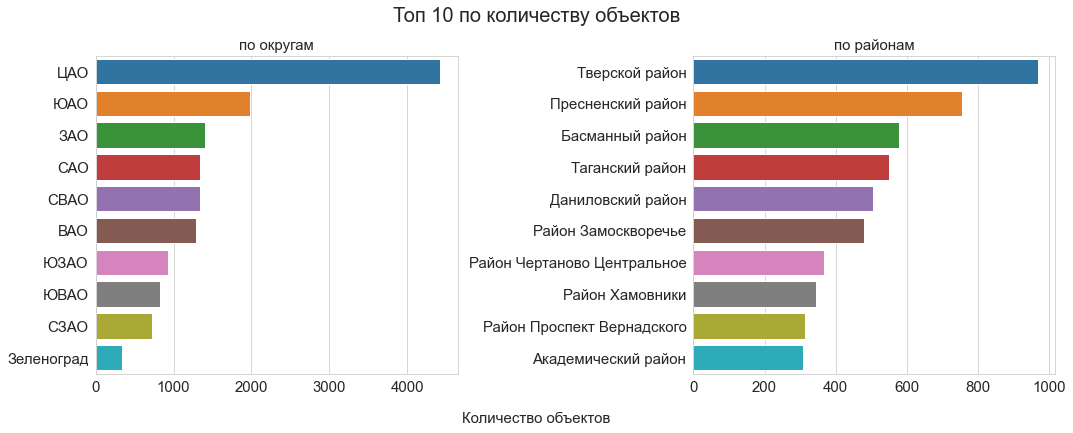

In [56]:
# визуализируем топ-10 по районам и административным округам

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

area_list = ['area', 'district']
axes = [ax1, ax2]
titles=['по округам', 'по районам', ]

for i in range(2):
    sns.barplot(data = top_locations(area_list[i])[:10], 
                x='object_count', y=area_list[i], ax=axes[i])
    
    axes[i].set(ylabel=None, xlabel=None, title=titles[i])
    axes[i].tick_params(labelsize=15)
    
fig.suptitle('Топ 10 по количеству объектов', size=20)
fig.supxlabel('Количество объектов', size=15)

plt.tight_layout()

plt.show()

- ЦАО лидирует по количеству предприятий с большим отрывом


- Самым популярным районом является Тверской район

Теперь исследуем конец списка - найдём количество улиц, на которых расположено одно заведение общественного питания:

Всего в данных представлено 122 уникальных района, 99 из них имеют улицы с 1 заведением.


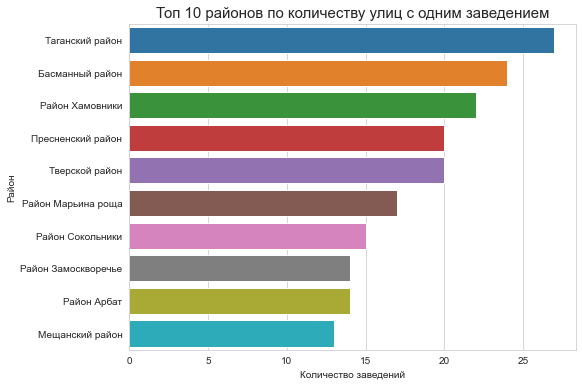

In [57]:
# группируем данные по районам

unpop_streets = (
    top_locations(['street', 'district'])
    .query('object_count == 1')
    .pivot_table(index='district', 
                 values = 'street', 
                 aggfunc='count')
    .sort_values('street', ascending=False)
    .reset_index()
)

# выводим 

print(f'Всего в данных представлено {len(data["district"].unique())} уникальных района, '
      f'{len(unpop_streets)} из них имеют улицы с 1 заведением.')

unpop_streets[:10]

# визуализируем топ-10 по количеству таких улицрезультат

plt.figure(figsize=(8, 6))

sns.barplot(data = unpop_streets[:10], 
            x='street', y='district')


plt.xlabel('Количество заведений')
plt.ylabel('Район')
plt.title('Топ 10 районов по количеству улиц с одним заведением')


plt.show()

- Список во многом совпадает с топом районов по количеству объектов, что говорит о том, что они имеют большой потенциал для успешного открытия новых предприятий.

<a id='presentation'></a>

## Вывод

____
**Рекомендации**

- Такие районы Москвы, как Таганский, Пресненский и Тверской имеют большой потенциал - несмотря на то, что они лидируют по количеству предприятий общественного питания, они всё ещё имеют улицу с лишь одним заведением.

- Самыми оптимальным выбором типа заведения будут такие виды, как кафе, ресторан и предприятие быстрого обслуживания. Для сетевого развития больше подойдет "фаст-фуд", а при желание сделать заведение с большим количеством посадочных мест - ресторан подойдёт лучше всего. Кафе является компромисным вариантом по всем параметрам, чем скорее всего и обусловлена подавляющая популярность такого формата.

____

**Презентация**: https://drive.google.com/file/d/1mRzHjcboKld9qi2FuJNjyNFISD-UZNVU/view?usp=sharing
____

Целью исследования являлось проведение исследовательского анализа рынка заведений общественного питания в Москве и подготовление презентации для потенциальных инвесторов, которые смогут использовать её для оценки инвестиционной привлекательности открытия нового ресторана.

**Ход исследования**

Для проекта были использованы открытые данные о заведениях общепита - адрес, количество посадочных мест, факт пренадлежности к какой-либо сети, а также тип предприятия по классификации заведений общественного питания в РФ <a href="https://docs.cntd.ru/document/1200107325">(**ГОСТ 30389-2013**)</a>. Данные были предобработаны и проанализированы, а на основании сделаных выводов была подготовлена презентация для инвесторов. Таким образом, исследование прошло в следующих этапах:

1. [**Обзор и предобработка данных**](#overview)

В ходе предобработки данных было удалено 4.48% датасета, при этом удалось сократить использование памяти на 23.33%. Большую часть данных удалось сохранить, а значительное сокращение используемых ресурсов памяти было достигнуто за счёт изменения типа данных, даже несмотря на формирование нескольких столбцов дополнительных данных.

Что было отмечено при работе с данными:

- Названия предприятий содержат множество неявных дубликатов, в основном обусловленных наличием опечаток или использованием разных регистров. В рамках исследования обработка названий заведений не оправдана - данных остальных столбцов будет достаточно для необходимых выводов.


- Некоторые улицы относятся одновременно к двум разным районам Москвы. В рамках исследования соотносить улицу с двумя районами технически невозможно, потому для каждой из них в случайном порядке был оставлен лишь одна локация - при формировании выводов необходимо будет сделать поправку на точность распределения заведений по районам.

2. [**Исследовательский анализ данных**](#EDA)

В ходе анализа были выполнены следующие шаги:

1. [**Исследования соотношения количества объектов общественного питания**](#EDA1)
2. [**Исследование соотношения количества посадочных мест в заведениях**](#EDA2)
3. [**Исследование распределения заведений по локациям**](#EDA3)

Общие выводы:

- Доля кафе составляет 40% от всех заведений. Вместе со столовыми, ресторанами, предприятиями быстрого питания и барами они составляют 90% всех предприятий Москвы.


- Сетевые предприятия составляют около 20% от всех заведений


- Кафе, рестораны и преприятия быстрого питания состовляют около 90% всех сетевых заведений.


- Несмотря на лидерство кафе по количеству сетевых заведений, предприятия быстрого обслуживания имеют самую значительную долю заведений, пренадлежащих к сети - 40%.


- В целом соотношение размеров предприятий сопоставимо, с небольшим отрывом лидируют средние по вместимости заведения.


- Корреляция средней вместимости и количества предприятий в сети полностью отсутствует.

- Столовые лидируют по количеству посадочных мест. Этот тип характерен не только высоким медианым значением, но и самым широким разбросом нормальных значений.

- Проспект Мира является лидирующей улицей по количеству заведений


- Округ ЦАО с большим отрывом лидирует по количеству предприятий 


- Самым популярным районом является Тверской район

- Всего в данных представлено 122 уникальных района, 99 из них имеют улицы с 1 заведением.

- Топ-10 районов по количеству улиц с одним заведением во многом совпадает с топом районов по количеству объектов, что может говорить о том, что они имеют большой потенциал для успешного открытия новых предприятий.